Notebook for training the convolutional autoencoder on dermatological data

In [1]:
!git clone https://github.com/Nomow/02456-deep-learning-image-denoising.git
!pip install -U albumentations
!pip install git+https://github.com/qubvel/segmentation_models.pytorch


Cloning into '02456-deep-learning-image-denoising'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 69 (delta 31), reused 50 (delta 14), pack-reused 0
Unpacking objects: 100% (69/69), done.
     |████████████████████████████████| 102 kB 7.9 MB/s 
     |████████████████████████████████| 47.6 MB 120 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ystw870u
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ystw870u
     |████████████████████████████████| 58 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 16.9 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorc

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/02456-deep-learning-image-denoising
from pathlib import Path
from dataset import AutoEncoderDataset
from utils import train
from utils import val
import matplotlib.pyplot as plt
import albumentations as albu
import segmentation_models_pytorch as smp
import os
import torch
from torch.utils.data import DataLoader
import albumentations.pytorch
import numpy as np

root_path = Path('/content/gdrive/MyDrive/dermatology_dataset') 
train_path = root_path / 'train/'
val_path = root_path / 'val/'
test_path = root_path / 'test/'
save_path = root_path / "experiment_unet"
# if not os.path.exists(save_path):
#     os.makedirs(save_path)



/content/02456-deep-learning-image-denoising


In [ ]:
img_max_size = 512
batch_print = 1
architecture = smp.UnetPlusPlus
encoder = 'timm-regnetx_016'
lr = 0.01
lr_step_size = 70
nb_epochs = 290
batch_size = 15
val_epoch = 5
weight_path = os.path.join("/content/weights", encoder + "-" + architecture.__name__)


net = architecture(encoder_name=encoder,  # UnetPlusPlus
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=3,
    )

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_016-65ca972a.pth" to /root/.cache/torch/hub/checkpoints/regnetx_016-65ca972a.pth


  0%|          | 0.00/35.3M [00:00<?, ?B/s]

In [11]:
def denormalize(img):
  image = np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1)
  MEAN = 255 * np.array([0.485, 0.456, 0.406])
  STD = 255 * np.array([0.229, 0.224, 0.225])
  image = ((image * STD)+ MEAN).astype(int)
  return image[...,::-1] #bgr to rgb

In [6]:
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

In [8]:
img_max_size = 512
batch_size = 15

train_transform = [
    albu.Blur(blur_limit=20, always_apply=False, p=0.6),
    albu.MultiplicativeNoise(multiplier=(0.7, 1.3), p=0.6),
    albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.4, brightness_by_max=True, always_apply=False, p=0.6),
    albu.Downscale(scale_min=0.25, scale_max=0.25, interpolation=0, always_apply=False, p=0.3),
    albu.ISONoise(color_shift=(0.08, 0.15), intensity=(0.2, 0.3), always_apply=False, p=0.6),
    albu.RandomToneCurve(scale=0.3, p=0.6)
    ]

train_transforms = albu.Compose(train_transform)

preprocess_transform = [
    albu.LongestMaxSize(max_size=img_max_size, always_apply=True),
    albu.PadIfNeeded(min_height=img_max_size, min_width=img_max_size, always_apply=True, border_mode=0),    
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    albumentations.pytorch.transforms.ToTensorV2()]

preprocess_transforms = albu.Compose(preprocess_transform)



In [9]:
train_dataset = AutoEncoderDataset(train_path, preprocess_transforms, train_transforms)
val_dataset = AutoEncoderDataset(val_path, preprocess_transforms, train_transforms)
test_dataset = AutoEncoderDataset(test_path, preprocess_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

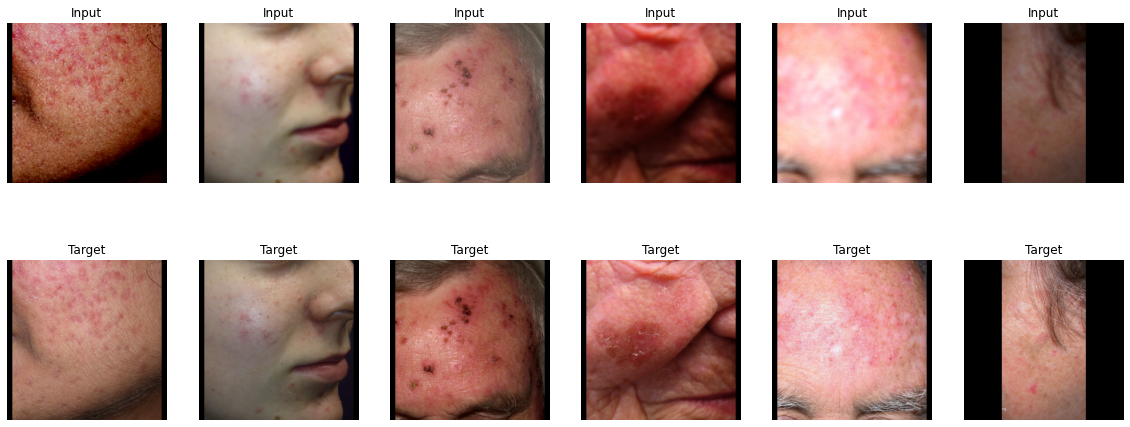

In [12]:
X_val, Y_val = next(iter(val_loader))


k = 0
fig = plt.figure(figsize=(20,8))
for m in range(6):
  plt.subplot(2, 6, k+1)
  plt.imshow(denormalize(X_val[m]))
  plt.title('Input')
  plt.axis('off')

  plt.subplot(2, 6, k+7)
  plt.imshow(denormalize(Y_val[m]))
  plt.title('Target')
  plt.axis('off')
  
  k+=1
plt.show()

## Conv autoencoder

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 512 -> 256
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 256 -> 128
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 128 -> 64
        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_batchnorm_3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool3 = nn.Conv2d(256, 256,2, padding=0, stride=2)  # 64 -> 32

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(128, 256, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256,256,2,stride=2)  # 32 -> 64
        self.dec_conv0 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(128)
        self.dec_dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample1 = nn.ConvTranspose2d(128,128,2,stride=2)   # 64 -> 128
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(64)
        self.dec_dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample2 = nn.ConvTranspose2d(64,64,2,stride=2)   # 128 -> 256
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample3 = nn.ConvTranspose2d(32,32,2,stride=2)   # 256 -> 512
        self.dec_conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.dec_batchnorm_3 = nn.BatchNorm2d(32)
        self.dec_dropout3 = nn.Dropout2d(p=0.1, inplace=False)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)


    def forward(self, x): 
        # encoder
        e0 = self.dropout0(F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x))))
        e1 = self.dropout1(F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0)))))
        e2 = self.dropout2(F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1)))))
        e3 = self.dropout3(F.leaky_relu(self.enc_batchnorm_3(self.enc_conv3(self.pool2(e2)))))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool3(e3)))))
       
        # decoder
        d0 = self.dec_dropout0(F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(self.upsample0(b)))))
        d1 = self.dec_dropout1(F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(self.upsample1(d0)))))
        d2 = self.dec_dropout2(F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(self.upsample2(d1)))))
        d3 = self.dec_dropout3(F.leaky_relu(self.dec_batchnorm_3(self.dec_conv3(self.upsample3(d2)))))
        out = F.tanh(self.dec_conv_fin(d3))
        return out

In [14]:
def train(model, opt, epochs):

    def loss_fun(y_real, y_pred):
      loss = torch.nn.MSELoss()
      output = loss(y_pred, y_real)
      return output

    X_val, Y_val = next(iter(val_loader))
    valid_loss_list = []
    train_loss_list = []

    scheduler =  torch.optim.lr_scheduler.StepLR(opt, lr_step_size, gamma=0.1, last_epoch=-1, verbose=False)

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        batch_loss_list = []
        model.train()  # train mode
        for minibatch_no, (X_batch, Y_batch) in enumerate(train_loader, 0):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fun(Y_batch, Y_pred)  # forward-pass
            batch_loss_list.append(loss.item())
            loss.backward()  # backward-pass
            opt.step()  # update weights
            scheduler.step()

        loss = np.mean(batch_loss_list)
        train_loss_list.append(loss)
        print(' - loss: %f' % loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()
        val_loss = loss_fun(Y_val, Y_hat)
        valid_loss_list.append(val_loss)
        predicted = Y_hat
        clear_output(wait=True)
        k = 0
        fig = plt.figure(figsize=(12,4))
        for m in range(6):
          plt.subplot(3, 6, k+1)
          plt.imshow(denormalize(X_val[m]))
          plt.title('Input')
          plt.axis('off')

          plt.subplot(3, 6, k+7)
          plt.imshow(denormalize(predicted[m]))
          plt.title('Output')
          plt.axis('off')

          plt.subplot(3, 6, k+13)
          plt.imshow(denormalize(Y_val[m]))
          plt.title('Target')
          plt.axis('off')
          
          k+=1
        plt.suptitle('%d / %d - loss: %f , val loss: %f' % (epoch+1, epochs, loss, val_loss))
        plt.show()

        fig = plt.figure(figsize=(12,4))
        plt.plot(train_loss_list, 'b', label = "Train loss")
        plt.plot(valid_loss_list, 'orange', label = "Validation loss")
        plt.legend()
        plt.show()
    return train_loss_list, valid_loss_list

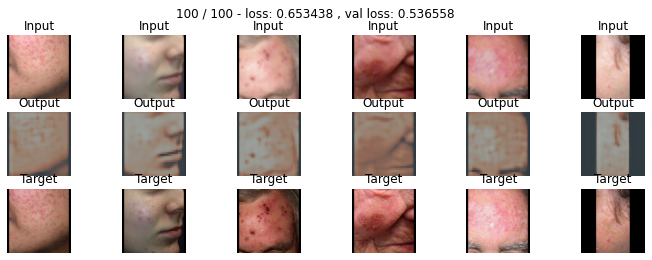

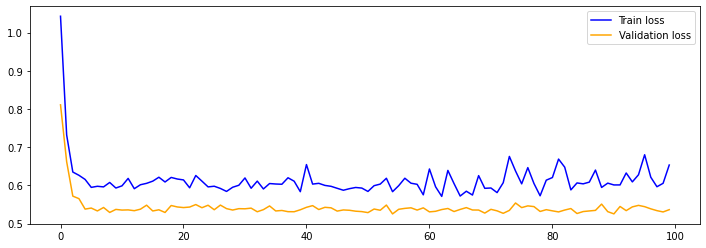

In [ ]:
model = ConvAutoEncoder().to(device)
train_loss_list, valid_loss_list = train(model, torch.optim.Adam(model.parameters(), lr=0.001), 100)

In [ ]:
save_path_autoencoder = root_path / "conv_autoencoder"
if not os.path.exists(save_path_autoencoder):
    os.makedirs(save_path_autoencoder)
torch.save(model.state_dict(), os.path.join(save_path_autoencoder, "best.pth"))

In [ ]:
logs = {}
logs["train"] = []
logs["val"] = []
logs["train"] = train_loss_list
logs["val"] = valid_loss_list

np.save(os.path.join(save_path_autoencoder, "logs.npy"), logs)